In [ ]:
# Menginstal library yang diperlukan
!pip install numpy pandas scikit-learn keras matplotlib rasterio

# Import library
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import rasterio
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 18.3 MB/s eta 0:00:00


In [ ]:
# Pengaturan direktori
input_folder = '/content/drive/MyDrive/kuliah/lulc 2017-2022/lc'  # Ganti dengan path folder input Anda
output_folder = '/content/drive/MyDrive/kuliah/lulc 2017-2022/lc'  # Ganti dengan path folder output Anda

# Membuat folder output jika belum ada
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


In [ ]:
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1)  # Membaca band pertama

# Membaca file raster
raster_2017 = read_raster(os.path.join(input_folder, '2017.tif'))
raster_2020 = read_raster(os.path.join(input_folder, '2020.tif'))
raster_2023 = read_raster(os.path.join(input_folder, '2023.tif'))

# Menggabungkan data
X = np.stack((raster_2017.ravel(), raster_2020.ravel()), axis=-1)
y = raster_2023.ravel()

# Normalisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
def create_random_forest():
    return RandomForestClassifier(n_estimators=100, random_state=42)

def create_ann():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(2,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Pilih model yang akan digunakan
model_choice = 'RF'  # Ganti dengan 'ANN' jika ingin menggunakan ANN

if model_choice == 'RF':
    model = create_random_forest()
else:
    model = create_ann()


In [ ]:
if model_choice == 'RF':
    model.fit(X_train, y_train)
else:
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=50, batch_size=32, verbose=1)


In [ ]:
def predict_2026(model, X_2023):
    if model_choice == 'RF':
        return model.predict(X_2023)
    else:
        return model.predict(X_2023).round()

X_2023 = np.stack((raster_2020.ravel(), raster_2023.ravel()), axis=-1)
X_2023_scaled = scaler.transform(X_2023)
prediction_2026 = predict_2026(model, X_2023_scaled)


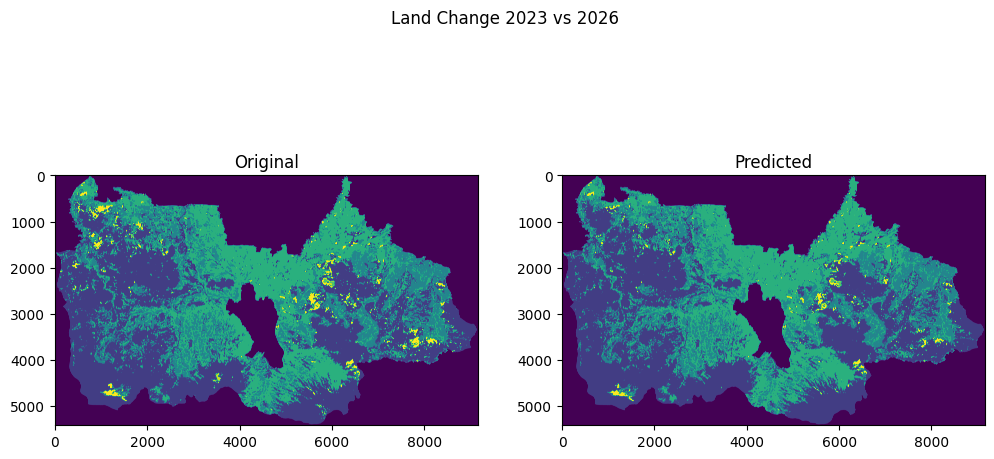

In [ ]:
def visualize_prediction(original, predicted, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(original)
    ax1.set_title('Original')
    ax2.imshow(predicted)
    ax2.set_title('Predicted')
    plt.suptitle(title)
    plt.savefig(os.path.join(output_folder, f'{title}.png'))
    plt.show()

visualize_prediction(raster_2023.reshape(raster_2017.shape),
                     prediction_2026.reshape(raster_2017.shape),
                     'Land Change 2023 vs 2026')


In [ ]:
# Menyimpan hasil prediksi
np.savetxt(os.path.join(output_folder, 'prediction_2026.csv'), prediction_2026, delimiter=',')

# Menyimpan model
if model_choice == 'RF':
    import joblib
    joblib.dump(model, os.path.join(output_folder, 'rf_model.joblib'))
else:
    model.save(os.path.join(output_folder, 'ann_model.h5'))

# Contoh cara memuat ulang model
if model_choice == 'RF':
    loaded_model = joblib.load(os.path.join(output_folder, 'rf_model.joblib'))
else:
    from keras.models import load_model
    loaded_model = load_model(os.path.join(output_folder, 'ann_model.h5'))


In [ ]:
import rasterio
from rasterio.transform import from_origin

# Tentukan file path untuk menyimpan file .tif
output_tif_path = os.path.join(output_folder, 'prediksi_2026.tif')

# Dapatkan dimensi asli dari raster
height, width = raster_2017.shape

# Buat transformasi affine untuk mengatur posisi geografis (ini contoh, sesuaikan dengan data Anda)
transform = from_origin(0, 0, 1, 1)  # Contoh transformasi (x_min, y_max, pixel_width, pixel_height)

# Simpan ke dalam file .tif
with rasterio.open(
    output_tif_path,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,  # Jumlah band, dalam hal ini 1
    dtype=prediction_2026.dtype,
    crs='EPSG:4326',  # Contoh CRS, sesuaikan dengan data Anda
    transform=transform,
) as dst:
    dst.write(prediction_2026.reshape(height, width), 1)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [ ]:
import rasterio
from rasterio.transform import from_origin

# Tentukan file path untuk menyimpan file .tif
output_tif_path = os.path.join(output_folder, 'prediksio_2026.tif')

# Dapatkan dimensi asli dari raster
height, width = raster_2017.shape

# Dapatkan informasi georeferensi dari raster asli
with rasterio.open(os.path.join(input_folder, '2023.tif')) as src:
    xmin = src.bounds.left
    ymax = src.bounds.top
    resolusi_x = src.res[0]
    resolusi_y = src.res[1]

# Buat transformasi affine untuk mengatur posisi geografis
transform = from_origin(xmin, ymax, resolusi_x, resolusi_y)

# Dapatkan CRS dari raster asli
with rasterio.open(os.path.join(input_folder, '2023.tif')) as src:
    crs = src.crs

# Simpan ke dalam file .tif
with rasterio.open(
    output_tif_path,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,  # Jumlah band, dalam hal ini 1
    dtype=prediction_2026.dtype,
    crs=crs,  # Gunakan CRS dari raster asli
    transform=transform,
) as dst:
    dst.write(prediction_2026.reshape(height, width), 1)

In [ ]:
from sklearn.metrics import accuracy_score

# Memastikan model adalah Random Forest
if model_choice == 'RF':
    # Melakukan prediksi pada data validasi
    y_pred = model.predict(X_val)

    # Menghitung akurasi
    accuracy_rf = accuracy_score(y_val, y_pred)
    print(f"Akurasi Random Forest: {accuracy_rf:.4f}")

Akurasi Random Forest: 0.9273


In [ ]:
###Hanya jika menggunakan ANN
if model_choice == 'ANN':
    # Menghitung akurasi pada data validasi
    _, accuracy_ann = model.evaluate(X_val, y_val, verbose=0)
    print(f"Akurasi ANN: {accuracy_ann:.4f}")


In [ ]:
from sklearn.metrics import mean_absolute_error

# Menghitung MAE
mae = mean_absolute_error(y_val, model.predict(X_val))
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 13.2013344807401


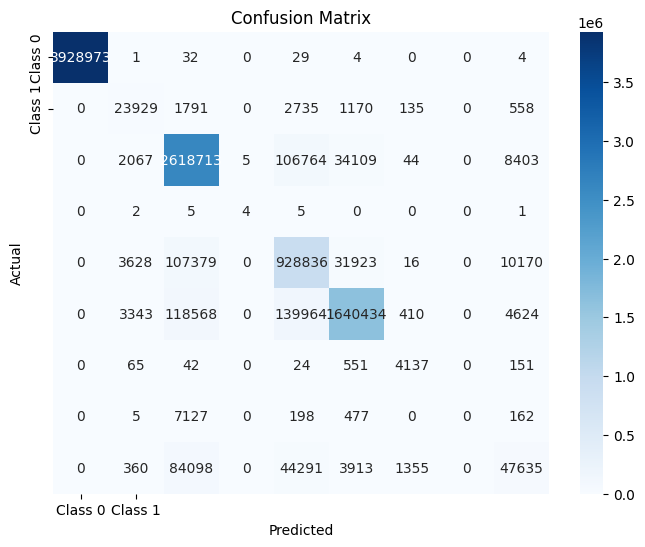

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Menghitung matriks kebingungan
cm = confusion_matrix(y_val, model.predict(X_val))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Menghitung nilai ROC dan AUC
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

ValueError: multiclass format is not supported

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Menghitung MSE dan RMSE
mse = mean_squared_error(y_val, model.predict(X_val))
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Squared Error: 1.7024301223933054
Root Mean Squared Error: 1.3047720576381552


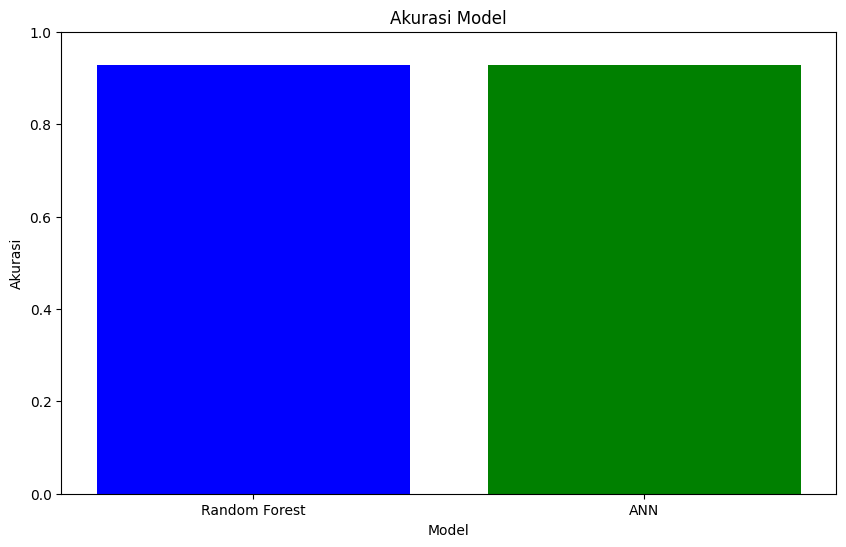

In [ ]:
import matplotlib.pyplot as plt

# Mengumpulkan data akurasi
model_names = ['Random Forest', 'ANN']
accuracies = []

if model_choice == 'RF':
    y_pred = model.predict(X_val)
    accuracy_rf = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy_rf)
else:
    _, accuracy_ann = model.evaluate(X_val, y_val, verbose=0)
    accuracies.append(accuracy_ann)

# Jika model ANN juga ada, tambahkan akurasi ke dalam list
if model_choice == 'ANN':
    accuracies.append(accuracy_ann)

# Plot akurasi
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Akurasi')
plt.title('Akurasi Model')
plt.ylim(0, 1)  # Rentang akurasi dari 0 hingga 1
plt.savefig(os.path.join(output_folder, 'model_accuracy.png'))
plt.show()

In [ ]:
# Menyimpan akurasi ke file teks
accuracy_file_path = os.path.join(output_folder, 'model_accuracy.txt')

with open(accuracy_file_path, 'w') as f:
    if model_choice == 'RF':
        y_pred = model.predict(X_val)
        accuracy_rf = accuracy_score(y_val, y_pred)
        f.write(f"Akurasi Random Forest: {accuracy_rf:.4f}\n")
    elif model_choice == 'ANN':
        _, accuracy_ann = model.evaluate(X_val, y_val, verbose=0)
        f.write(f"Akurasi ANN: {accuracy_ann:.4f}\n")


In [ ]:
import seaborn as sns
import numpy as np

# Buat data dummy untuk heatmap (misalnya matriks akurasi per model)
data = np.array([[accuracy_rf if model_choice == 'RF' else np.nan],
                 [accuracy_ann if model_choice == 'ANN' else np.nan]])

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(data, annot=True, cmap='YlGnBu', xticklabels=model_names, yticklabels=['Accuracy'])
plt.title('Heatmap Akurasi Model')
plt.savefig(os.path.join(output_folder, 'model_accuracy_heatmap.png'))
plt.show()


In [ ]:
import joblib

# Menyimpan semua variabel dalam satu file
data_to_save = {
    'model': model,
    'X_val': X_val,
    'y_val': y_val,
    'y_pred': y_pred
}

joblib.dump(data_to_save, os.path.join(output_folder, 'model_and_data.pkl'))

['/content/drive/MyDrive/kuliah/lulc 2017-2022/lc/model_and_data.pkl']

In [ ]:
# Contoh cross-validation untuk Random Forest
from sklearn.model_selection import cross_val_score

if model_choice == 'RF':
    cv_scores = cross_val_score(model, X_scaled, y, cv=5)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean()}")

# Saran untuk optimasi
print("Saran optimasi:")
print("1. Lakukan grid search untuk menemukan hyperparameter terbaik")
print("2. Coba teknik ensemble seperti bagging atau boosting")
print("3. Tambahkan fitur tambahan seperti elevasi atau jarak ke pusat kota")
print("4. Gunakan teknik augmentasi data jika dataset terlalu kecil")


KeyboardInterrupt: 

Perbandingan Luas Area Kelas:
        2023  2026 (Prediksi)  Perubahan
0   19640976       19640567.0     -409.0
1     151934         142831.0    -9103.0
2   13853432       14134216.0   280784.0
4        115             74.0      -41.0
5    5411112        5303296.0  -107816.0
7    9538935        9768376.0   229441.0
8      25123          22498.0    -2625.0
10     39831              NaN        NaN
11    905383         554983.0  -350400.0


<Figure size 1200x600 with 0 Axes>

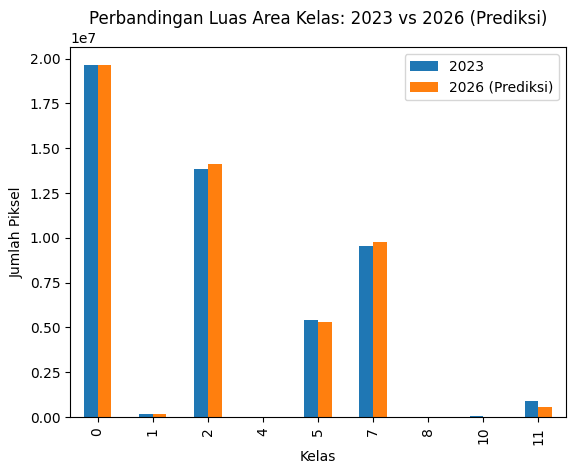

In [ ]:
#### 11. Analisis Perbedaan Kelas dan Luasan

# Fungsi untuk menghitung luas area setiap kelas
def calculate_area(raster):
    unique, counts = np.unique(raster, return_counts=True)
    return dict(zip(unique, counts))

# Menghitung luas area untuk data asli 2023 dan prediksi 2026
area_2023 = calculate_area(raster_2023)
area_2026 = calculate_area(prediction_2026.reshape(raster_2017.shape))

# Membuat DataFrame untuk perbandingan
df_comparison = pd.DataFrame({
    '2023': area_2023,
    '2026 (Prediksi)': area_2026
})
df_comparison['Perubahan'] = df_comparison['2026 (Prediksi)'] - df_comparison['2023']

print("Perbandingan Luas Area Kelas:")
print(df_comparison)

# Visualisasi perbandingan menggunakan bar chart
plt.figure(figsize=(12, 6))
df_comparison[['2023', '2026 (Prediksi)']].plot(kind='bar')
plt.title('Perbandingan Luas Area Kelas: 2023 vs 2026 (Prediksi)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Piksel')
plt.legend(['2023', '2026 (Prediksi)'])
plt.savefig(os.path.join(output_folder, 'area_comparison.png'))
plt.show()

Perbandingan Luas Area Kelas:
        2023  2026 (Prediksi)  Perubahan
0   19640976       19640567.0     -409.0
1     151934         142831.0    -9103.0
2   13853432       14134216.0   280784.0
4        115             74.0      -41.0
5    5411112        5303296.0  -107816.0
7    9538935        9768376.0   229441.0
8      25123          22498.0    -2625.0
10     39831              NaN        NaN
11    905383         554983.0  -350400.0


<Figure size 1200x600 with 0 Axes>

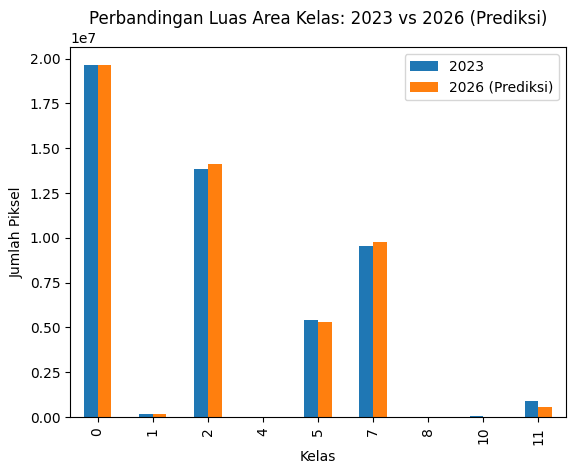

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Fungsi untuk menghitung luas area setiap kelas
def calculate_area(raster):
    unique, counts = np.unique(raster, return_counts=True)
    return dict(zip(unique, counts))

# Menghitung luas area untuk data asli 2023 dan prediksi 2026
area_2023 = calculate_area(raster_2023)
area_2026 = calculate_area(prediction_2026.reshape(raster_2017.shape))

# Membuat DataFrame untuk perbandingan
df_comparison = pd.DataFrame({
    '2023': pd.Series(area_2023),
    '2026 (Prediksi)': pd.Series(area_2026)
})
df_comparison['Perubahan'] = df_comparison['2026 (Prediksi)'] - df_comparison['2023']

print("Perbandingan Luas Area Kelas:")
print(df_comparison)

# Menyimpan DataFrame ke file CSV
df_comparison.to_csv(os.path.join(output_folder, 'area_comparison.csv'), index_label='Kelas')

# Visualisasi perbandingan menggunakan bar chart
plt.figure(figsize=(12, 6))
df_comparison[['2023', '2026 (Prediksi)']].plot(kind='bar')
plt.title('Perbandingan Luas Area Kelas: 2023 vs 2026 (Prediksi)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Piksel')
plt.legend(['2023', '2026 (Prediksi)'])
plt.savefig(os.path.join(output_folder, 'area_comparison.png'))
plt.show()


In [ ]:
### 12. Menyimpan Peta Hasil Prediksi sebagai GeoTIFF

# Fungsi untuk menyimpan hasil prediksi sebagai GeoTIFF
def save_prediction_as_geotiff(prediction, reference_file, output_file):
    with rasterio.open(reference_file) as src:
        profile = src.profile

    # Update profil untuk hasil prediksi
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw'
    )

    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(prediction.astype(rasterio.uint8), 1)

# Menyimpan hasil prediksi 2026 sebagai GeoTIFF
prediction_2026_reshaped = prediction_2026.reshape(raster_2017.shape)
save_prediction_as_geotiff(
    prediction_2026_reshaped,
    os.path.join(input_folder, '2023.tif'),
    os.path.join(output_folder, 'prediction_2026.tif')
)

print(f"Hasil prediksi 2026 telah disimpan sebagai GeoTIFF di: {os.path.join(output_folder, 'prediction_2026.tif')}")


Hasil prediksi 2026 telah disimpan sebagai GeoTIFF di: /content/drive/MyDrive/kuliah/lulc 2017-2022/lc/prediction_2026.tif
